# Sentiment Prediction Model

In [1]:
import pandas as pd
import numpy as np

from sentiment_analysis import (database as db, entities as et, util)

In [2]:
onehot = et.SigWordUse.onehot()
train, test = onehot.iloc[:,3:], onehot['_rating']
game_reviews = pd.read_sql_table('game_review', db.engine)
sig_words = pd.read_sql_table('sig_word', db.engine)
weights = pd.Series(sig_words.median_q50.values, index=sig_words.word).sort_index()

### RMSE: 1.57204

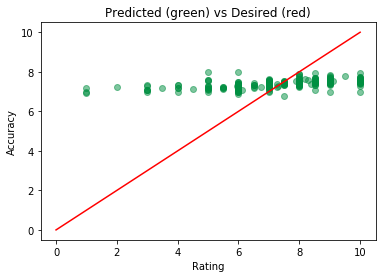

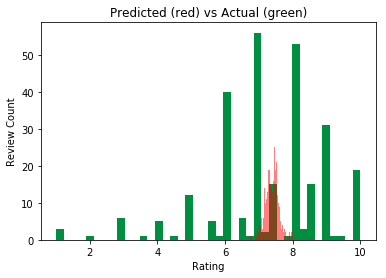

In [3]:
Qone = train.multiply(weights)
N_total = train.sum(axis=1)
predictions = Qone.sum(axis=1) / N_total
util.plot_results(test, predictions)

# Alpha scaling with multipliers and exponents

## Method 1: Scale distance from median

In [4]:
np.percentile(game_reviews.rating, 50)

7.5

### RMSE: 1.51633

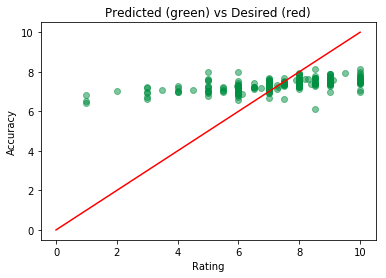

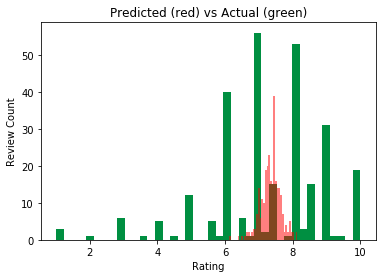

In [5]:
distance_point = game_reviews.rating.median()
alpha = abs(weights - distance_point) + 1
Qone_scaled = Qone.multiply(alpha, axis=1)
N_total = train.multiply(alpha, axis=1).sum(axis=1)
predictions = Qone_scaled.sum(axis=1) / N_total
util.plot_results(test, predictions)

## Method 2: Scale linear multiplicative

(includes Method 1)

In [6]:
multiplers = []
for multipler in range(0, 1001, 10):
    if multipler == 0:
        continue
    alpha = multipler * abs(weights - 7.5) + 1
    Qone_scaled = Qone.multiply(alpha, axis=1)
    N_total = train.multiply(alpha, axis=1).sum(axis=1)
    predictions = Qone_scaled.sum(axis=1) / N_total
    rmse = util.rmse(test, predictions)
    multiplers.append([multipler, rmse])
multipler_df = pd.DataFrame(multiplers, columns=['multipler', 'rmse'])
multipler_df.nsmallest(1, 'rmse')

,multipler,rmse
99,1000,1.424158


### RMSE: 1.42416

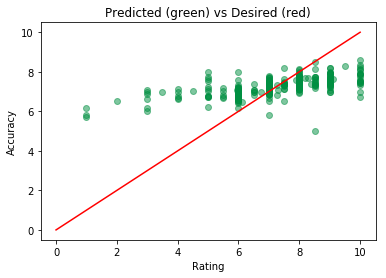

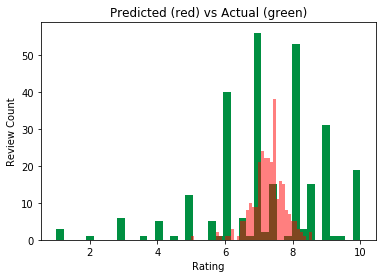

In [7]:
multipler = 1000
distance_point = game_reviews.rating.median()
alpha = multipler * abs(weights - distance_point) + 1
Qone_scaled = Qone.multiply(alpha, axis=1)
N_total = train.multiply(alpha, axis=1).sum(axis=1)
predictions = Qone_scaled.sum(axis=1) / N_total
util.plot_results(test, predictions)

## Method 3: Power scaling

(includes method 1)

In [8]:
powers = []
for power in [1, 1.2, 1.4, 1.6, 1.8, 2, 2.5, 3, 3.5, 4, 4.5, 5]:
    alpha = abs(weights - 7.5)**power + 1
    Qone_scaled = Qone.multiply(alpha, axis=1)
    N_total = train.multiply(alpha, axis=1).sum(axis=1)
    predictions = Qone_scaled.sum(axis=1) / N_total
    rmse = util.rmse(test, predictions)
    powers.append([power, rmse])
powers_df = pd.DataFrame(powers, columns=['power', 'rmse'])
powers_df.nsmallest(1, 'rmse')

,power,rmse
9,4.0,1.417832


### RMSE: 1.41783

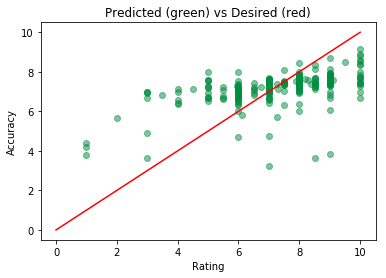

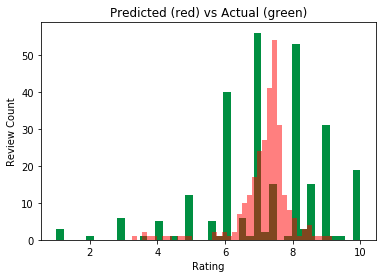

In [9]:
power = 4
distance_point = game_reviews.rating.median()
alpha = abs(weights - distance_point)**power + 1
Qone_scaled = Qone.multiply(alpha, axis=1)
N_total = train.multiply(alpha, axis=1).sum(axis=1)
predictions = Qone_scaled.sum(axis=1) / N_total
util.plot_results(test, predictions)

## Combining Methods 1, 2, and 3

In [10]:
multiplers = [1, 10, 100, 1000]
powers = [1, 1.2, 1.4, 1.6, 1.8, 2, 2.5, 3, 3.5, 4, 4.5, 5]
distance_point = game_reviews.rating.mean()
combinations = []
for multipler in multiplers:
    for power in powers:
        alpha = multipler * abs(weights - 7.5)**power + 1
        Qone_scaled = Qone.multiply(alpha, axis=1)
        N_total = train.multiply(alpha, axis=1).sum(axis=1)
        predictions = Qone_scaled.sum(axis=1) / N_total
        combinations.append([multipler, power, util.rmse(test, predictions)])
combinations_df = pd.DataFrame(combinations, columns=['multipler', 'power', 'rmse'])
combinations_df.nsmallest(1, 'rmse')

,multipler,power,rmse
41,1000,2.0,1.349164


### RMSE: 1.34916

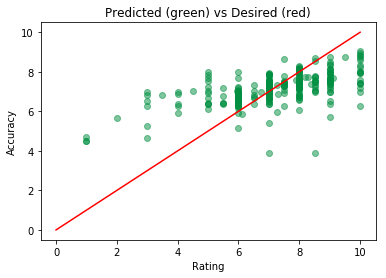

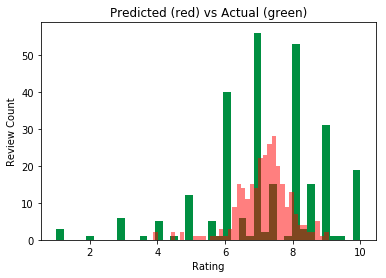

In [11]:
multipler = 1000
power = 2
distance_point = game_reviews.rating.median()
alpha = multipler * abs(weights - distance_point)**power + 1
Qone_scaled = Qone.multiply(alpha, axis=1)
N_total = train.multiply(alpha, axis=1).sum(axis=1)
predictions = Qone_scaled.sum(axis=1) / N_total
util.plot_results(test, predictions)

# Beta scaling based off dispersion

## Method 1: penalize deviation from IQR

### RMSE: 1.57264

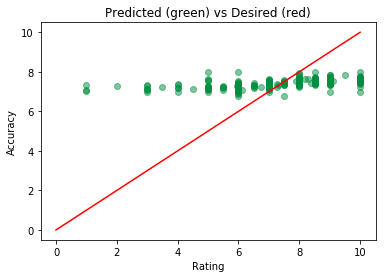

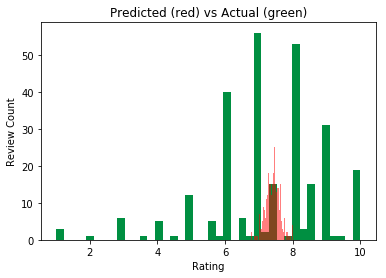

In [12]:
dispersion = 1 - (sig_words.iqr / sig_words.iqr.max())
beta = pd.Series(dispersion.values, index=sig_words.word).sort_index()
Qone_scaled = Qone.multiply(beta, axis=1)
N_total = train.multiply(beta, axis=1).sum(axis=1)
predictions = Qone_scaled.sum(axis=1) / N_total
util.plot_results(test, predictions)

## Method 2: Reward tight IQR

### RMSE: 1.55508

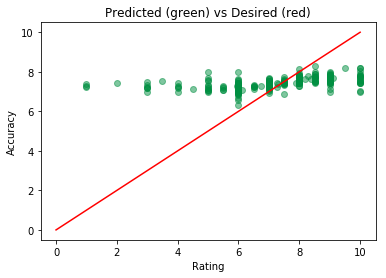

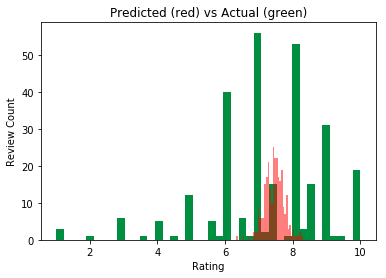

In [13]:
dispersion = np.exp(abs(sig_words.iqr - sig_words.iqr.max()))
beta = pd.Series(dispersion.values, index=sig_words.word).sort_index()
Qone_scaled = Qone.multiply(beta, axis=1)
N_total = train.multiply(beta, axis=1).sum(axis=1)
predictions = Qone_scaled.sum(axis=1) / N_total
util.plot_results(test, predictions)

# Combine Alpha and Beta Scaling

### RMSE: 1.30134

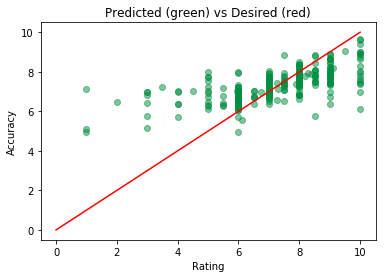

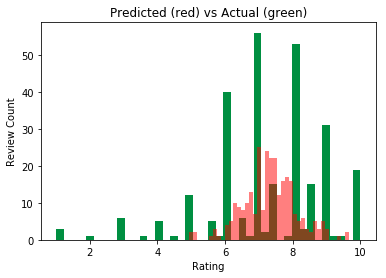

In [14]:
multipler = 1000
power = 2
distance_point = game_reviews.rating.median()
alpha = multipler * abs(weights - distance_point)**power + 1

dispersion = np.exp(abs(sig_words.iqr - sig_words.iqr.max()))
beta = pd.Series(dispersion.values, index=sig_words.word).sort_index()

dispersion = 1 - (sig_words.iqr / sig_words.iqr.max())
gamma = pd.Series(dispersion.values, index=sig_words.word).sort_index()

Qone_scaled = Qone.multiply(alpha*beta, axis=1)
N_total = train.multiply(alpha*beta, axis=1).sum(axis=1)
predictions = Qone_scaled.sum(axis=1) / N_total
util.plot_results(test, predictions)